Saving liquidations.csv to liquidations (7).csv


Saving fear_greed_index.csv to fear_greed_index (4).csv

Daily aggregates with sentiment sample:
        date  trade_count  total_notional  avg_leverage  daily_pnl  \
0 2023-02-28            1               0           0.0          0   
1 2023-03-02            1               0           0.0          0   
2 2023-03-03            2               0           0.0          0   
3 2023-03-08            1               0           0.0          0   
4 2023-03-10            1               0           0.0          0   
5 2023-03-11            3               0           0.0          0   
6 2023-03-12            3               0           0.0          0   
7 2023-03-13            2               0           0.0          0   
8 2023-03-18            1               0           0.0          0   
9 2023-03-19            1               0           0.0          0   

  classification  sentiment_bin  
0        neutral            NaN  
1        neutral            NaN  
2        neutral            Na

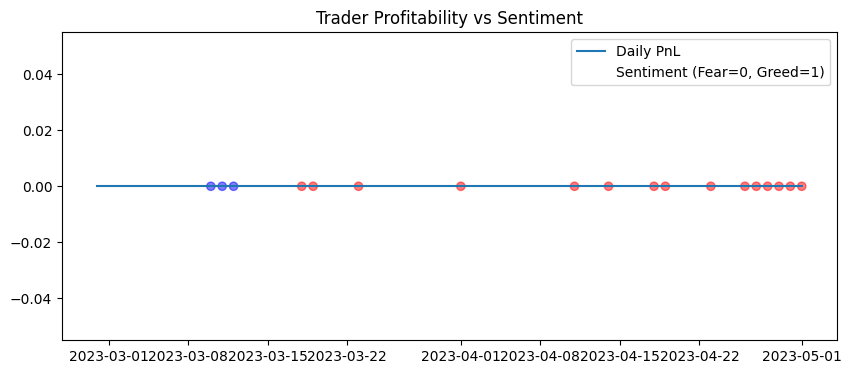


Saved merged dataset → sentiment_trader_merged.csv


In [11]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()
uploaded = files.upload()

sent = pd.read_csv('fear_greed_index.csv')
trades = pd.read_csv('liquidations.csv')

sent.columns = [c.strip().lower() for c in sent.columns]
sent['date'] = pd.to_datetime(sent['date'], errors='coerce').dt.floor('D')
sent['classification'] = sent['classification'].str.strip().str.lower()
sent['sentiment_bin'] = sent['classification'].map({'fear':0, 'greed':1})

trades.columns = [c.strip().lower() for c in trades.columns]
time_col = next((c for c in trades.columns if 'time' in c), trades.columns[0])
trades['time'] = pd.to_datetime(trades[time_col], errors='coerce')
trades['date'] = trades['time'].dt.floor('D')

for col in ['execution price', 'size', 'closedpnl', 'leverage']:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')
    else:
        trades[col] = 0

trades['closedpnl'] = trades['closedpnl'].fillna(0)


daily = trades.groupby('date').agg(
    trade_count = ('size','count'),
    total_notional = ('size', 'sum'),
    avg_leverage = ('leverage','mean'),
    daily_pnl = ('closedpnl','sum')
).reset_index()

sent['date'] = pd.to_datetime(sent['date'], errors='coerce').dt.floor('D').dt.tz_localize(None)
daily['date'] = pd.to_datetime(daily['date'], errors='coerce').dt.floor('D').dt.tz_localize(None)
merged = pd.merge(daily, sent[['date','classification','sentiment_bin']], on='date', how='left')

print("\nDaily aggregates with sentiment sample:")
print(merged.head(10))

print("\nMedians grouped by sentiment (0=fear,1=greed):")
print(merged.groupby('sentiment_bin')[['total_notional','avg_leverage','daily_pnl']].median())

plt.figure(figsize=(10,4))
plt.plot(merged['date'], merged['daily_pnl'], label='Daily PnL')
plt.scatter(merged['date'], merged['sentiment_bin']*merged['daily_pnl'].max(),
            c=merged['sentiment_bin'], cmap='bwr', alpha=0.5, label='Sentiment (Fear=0, Greed=1)')
plt.title("Trader Profitability vs Sentiment")
plt.legend()
plt.show()

merged.to_csv('sentiment_trader_merged.csv', index=False)
print("\nSaved merged dataset → sentiment_trader_merged.csv")



In [5]:
!mkdir -p ds_osh_gupta/csv_files
!mkdir -p ds_osh_gupta/outputs
